<a href="https://colab.research.google.com/github/scalablefeaturekd/scalable_pink_team/blob/main/KD_sequential_stepwise_grid_search_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
import torchvision
import torchvision.models as models
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
torch.cuda.manual_seed(0)


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## magic number

In [ ]:
drive_folder_p="/content/drive/MyDrive/cifar_10_not_pretrained_fine_tunning_results_v2"
weights_p=None
batch_size_p = 64
epochs_tuning_p = 10
epochs_training_p = 20
lr_p = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialization

## Prepare Data

In [ ]:
transform_list = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100", train=True, download=True, transform=transform_list)
test_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100", train=False, download=True, transform=transform_list)

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


## Basic Functions

In [ ]:
def distillation(student_logits, true_labels, teacher_logits, T=4.0, alpha=0.7):
    soft_target = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    hard_target = F.cross_entropy(student_logits, true_labels)
    return alpha * soft_target + (1 - alpha) * hard_target

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_experiment_results(
    student_model,
    best_hparams,
    best_model_history,
    all_stepwise_results,
    experiment_name="my_experiment",
    drive_folder="/content/drive/MyDrive/experiment_results/"
):
    """
    Save the student's state_dict and the experiment data (hparams, history, etc.)
    into Google Drive.

    Args:
        student_model (nn.Module): The trained student model.
        best_hparams (dict): Dictionary containing the best hyperparameters.
        best_model_history (list): The epoch-wise (test_loss, test_acc) for the best config.
        all_stepwise_results (dict): Records of all searches across the three steps.
        experiment_name (str): A name used to generate the output file names.
        drive_folder (str): The folder path in Google Drive where results are stored.

    Returns:
        (model_path, data_path): The paths of the saved model file (.pt) and data file (.pkl).
    """
    import os
    import torch
    import pickle

    # 1) Ensure the drive folder exists
    os.makedirs(drive_folder, exist_ok=True)

    # 2) Construct the file paths
    model_path = os.path.join(drive_folder, f"{experiment_name}_model.pt")
    data_path = os.path.join(drive_folder, f"{experiment_name}_data.pkl")

    # 3) Save the model's state_dict to a .pt file
    torch.save(student_model.state_dict(), model_path)
    print(f"Saved model to: {model_path}")

    # 4) Pack the other experiment data into one dict
    data_dict = {
        "best_hparams": best_hparams,
        "best_model_history": best_model_history,
        "all_stepwise_results": all_stepwise_results
    }

    # 5) Save the data_dict to a .pkl file
    with open(data_path, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Saved experiment data to: {data_path}")

    return model_path, data_path


In [ ]:
def load_results_from_drive(
    student_class,
    experiment_name="my_experiment",
    drive_folder="/content/drive/MyDrive/experiment_results/",
    device="cuda"
):
    """
    Load a student model's state_dict and related experiment data from Google Drive.

    Args:
        student_class: The class of the student network (e.g., StudentNet_MultiLayer).
        experiment_name: The name used to locate the .pt and .pkl files.
        drive_folder: The folder path in Google Drive where the files are stored.
        device: 'cuda' or 'cpu'.

    Returns:
        student_model (nn.Module): The loaded student model (in eval mode).
        best_hparams (dict): The best hyperparameters that were saved.
        best_model_history (list): The epoch-wise (test_loss, test_acc) for the best config.
        all_stepwise_results (dict): The full stepwise search records.
    """
    import os
    import torch
    import pickle

    # 1) Construct file paths
    model_path = os.path.join(drive_folder, f"{experiment_name}_model.pt")
    data_path = os.path.join(drive_folder, f"{experiment_name}_data.pkl")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")

    # 2) Re-instantiate the student model
    student_model = student_class().to(device)

    # 3) Load the model's state_dict
    student_model.load_state_dict(torch.load(model_path, map_location=device))
    student_model.eval()

    # 4) Load the other experiment data (best_hparams, best_model_history, etc.)
    with open(data_path, 'rb') as f:
        data_dict = pickle.load(f)

    best_hparams = data_dict["best_hparams"]
    best_model_history = data_dict["best_model_history"]
    all_stepwise_results = data_dict["all_stepwise_results"]

    print(f"Loaded model from {model_path}")
    print(f"Loaded experiment data from {data_path}")

    return student_model, best_hparams, best_model_history, all_stepwise_results


# Teacher Model

In [ ]:
class TeacherResNet50(nn.Module):
    def __init__(self):
        super(TeacherResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)

        x = self.resnet50.layer1(x)
        layer1_out = x

        x = self.resnet50.layer2(x)
        layer2_out = x

        x = self.resnet50.layer3(x)
        layer3_out = x

        x = self.resnet50.layer4(x)
        layer4_out = x

        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet50.fc(x)

        # Return a dict of all layer outputs + final classifier output
        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output

In [ ]:
def train_teacher_femain_teacher_fe(model,device,train_loader,optimizer,epoch):
  model.train()
  trained_samples = 0

  for batch_idx,(data,target) in enumerate(train_loader):
    data,target = data.to(device),target.to(device)
    _,output = model(data)
    optimizer.zero_grad()
    loss = F.cross_entropy(output,target)
    loss.backward()
    optimizer.step()

    trained_samples += len(data)
    progress = math.ceil((batch_idx) / len(train_loader) * 50)
    print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
            (epoch, trained_samples,len(train_loader.dataset),'-' * progress + ">", progress * 2),end="")

def test_teacher_femain_teacher_fe(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data,target in test_loader:
      data,target = data.to(device),target.to(device)
      _,output = model(data)
      test_loss += F.cross_entropy(output,target,reduction="sum").item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)



  print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  return test_loss, correct / len(test_loader.dataset)

In [ ]:
def main_teacher_fe():
  batch_size = batch_size_p
  epochs = epochs_training_p
  torch.manual_seed(0)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  transform_list = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
  ])

  train_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100",train=True,download=True,transform=transform_list)
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle=True)
  test_dataset = torchvision.datasets.CIFAR100("./data/CIFAR100",train=False,download=True,transform=transform_list)
  test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True)
  model = TeacherResNet50().to(device)
  #adadelta ==> very very very very slow
  # optimizer = torch.optim.Adadelta(model.parameters())
  lr = lr_p
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
  teacher_history = []
  for epoch in range(1,epochs+1):
    train_teacher_femain_teacher_fe(model,device,train_loader,optimizer,epoch)
    loss,acc = test_teacher_femain_teacher_fe(model,device,test_loader)
    teacher_history.append((loss, acc))
  torch.save(model.state_dict(), "teacher_fe_tuning.pt")
  return model, teacher_history


In [ ]:
teacher_model,teacher_history=main_teacher_fe()

save_experiment_results(
    teacher_model,
    [],
    [],
    teacher_history,
    experiment_name="teacher_resnet50",
    drive_folder=drive_folder_p
)

# Student-Resnet-18

## Model and Basic Functions

In [ ]:
class TeacherResNet50(nn.Module):
    def __init__(self):
        super(TeacherResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)

        x = self.resnet50.layer1(x)
        layer1_out = x

        x = self.resnet50.layer2(x)
        layer2_out = x

        x = self.resnet50.layer3(x)
        layer3_out = x

        x = self.resnet50.layer4(x)
        layer4_out = x

        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet50.fc(x)

        # Return a dict of all layer outputs + final classifier output
        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output

In [ ]:
teacher_model = TeacherResNet50().to(device)
teacher_model.load_state_dict(torch.load("teacher_fe.pt"))
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

In [ ]:
class StudentResNet18(nn.Module):
    def __init__(self):
        super(StudentResNet18, self).__init__()
        self.resnet18 = models.resnet18(weights=weights_p)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        layer1_out = x

        x = self.resnet18.layer2(x)
        layer2_out = x

        x = self.resnet18.layer3(x)
        layer3_out = x

        x = self.resnet18.layer4(x)
        layer4_out = x

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        layer_preLogits=x

        output = self.resnet18.fc(x)

        return {
            'layer1': layer1_out,
            'layer2': layer2_out,
            'layer3': layer3_out,
            'layer4': layer4_out,
            'layer_preLogits': layer_preLogits
        }, output


In [ ]:
# ================== 1) Global channel dicts ==================
teacher_channels_dict = {
    'layer1': 256,
    'layer2': 512,
    'layer3': 1024,
    'layer4': 2048,
    'layer_preLogits': 2048
}

student_channels_dict = {
    'layer1': 64,
    'layer2': 128,
    'layer3': 256,
    'layer4': 512,
    'layer_preLogits': 512
}

def build_projections_for_fitnet(chosen_layers):
    """
    Build projection layers for FitNet based on the global teacher_channels_dict
    and student_channels_dict, specifically for the given chosen_layers.
    """
    import torch.nn as nn

    projections = nn.ModuleDict()

    for lay in chosen_layers:
        t_dim = teacher_channels_dict[lay]
        s_dim = student_channels_dict[lay]

        if t_dim == s_dim:
            projections[lay] = nn.Identity()
        else:
            if lay == "layer_preLogits":
                # a 2D feature -> use Linear
                layer_seq = nn.Sequential(
                    nn.Linear(t_dim, s_dim),
                    nn.ReLU()
                )
            else:
                # a 4D feature map -> use 1x1 Conv2d + BN + ReLU
                layer_seq = nn.Sequential(
                    nn.Conv2d(in_channels=t_dim, out_channels=s_dim, kernel_size=1),
                    nn.BatchNorm2d(s_dim),
                    nn.ReLU()
                )
            projections[lay] = layer_seq

    return projections


In [ ]:
def attention_map(feat_map):
    # feat_map: (B, C, H, W)
    # 1) mean of squares across channel
    am = feat_map.pow(2).mean(1, keepdim=True)   # (B, 1, H, W)
    # 2) L2 normalize
    am = F.normalize(am, p=2, dim=(2, 3))        # normalize across spatial dims
    return am


def at_loss(student_map, teacher_map):
    return F.mse_loss(student_map, teacher_map)

In [ ]:
def test_student(model, device, test_loader):

    model.eval()  # set to eval mode
    test_loss = 0.0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # forward pass
            _, output = model(data)

            # compute loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # compute accuracy
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # average over entire dataset
    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)


    print('Test: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, accuracy


## train one epoch

In [ ]:
def train_one_epoch_multi(
    kd_method,
    student_model,
    teacher_model,
    device,
    train_loader,
    optimizer,
    epoch,
    feature_based_alpha=0.3,
    chosen_layer_combo=('layer3',),
    response_based_alpha=0.9,
    T=4.0,
    projections=None
):


    import torch
    import torch.nn.functional as F

    mse_loss_fn = torch.nn.MSELoss()
    student_model.train()
    teacher_model.eval()
    trained_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # forward student
        student_feats, student_output = student_model(data)

        # forward teacher
        with torch.no_grad():
            teacher_feats, teacher_output = teacher_model(data)

        loss_fb_sum = 0.0
        if kd_method == "fitnet-kd":
            # Summation of MSE across chosen_layer_combo
            for lay in chosen_layer_combo:
                s_feat = student_feats[lay]
                t_feat = teacher_feats[lay].detach()

                # If we have a projection for this layer, call it
                if projections is not None and lay in projections:
                    t_feat = projections[lay](t_feat)

                loss_fb_sum += mse_loss_fn(s_feat, t_feat)

        elif kd_method == "at-kd":
            for lay in chosen_layer_combo:
                s_feat = student_feats[lay]
                t_feat = teacher_feats[lay].detach()
                s_att = attention_map(s_feat)
                t_att = attention_map(t_feat)
                loss_fb_sum += at_loss(s_att, t_att)

        loss_rb = 0.0
        loss_ce = 0.0
        if kd_method in ("fitnet-kd", "resp-kd", "at-kd"):
            loss_rb = distillation(
                student_output,
                target,
                teacher_output,
                T=T,
                alpha=response_based_alpha
            )
        elif kd_method == "no-kd":
            loss_ce = F.cross_entropy(student_output, target)

        # Weighted combination
        loss_fb = feature_based_alpha * loss_fb_sum
        loss_rb_final = (1 - feature_based_alpha) * loss_rb
        # print()
        # print(loss_fb,loss_rb_final,loss_ce)
        # print()
        total_loss = 20*loss_fb + loss_rb_final + loss_ce
        # print(total_loss)
        total_loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = (batch_idx + 1) / len(train_loader) * 50
        bar = f"[{'-' * int(progress)}>".ljust(51, ' ')
        print(
            f"\rTrain epoch {epoch}: {trained_samples}/{len(train_loader.dataset)}, "
            f"{bar} {int(progress)*2}%",
            end=""
        )

    print()


## Train 1 kd hparam set

In [ ]:
def train_kd_once(
    kd_method,
    teacher_model,
    device,
    train_dataset,
    test_dataset,
    chosen_layer_combo=('layer3',),
    feature_based_alpha=0.3,
    response_based_alpha=0.9,
    T=4.0,
    lr=None,
    epochs=None,
    projections=None
):
    """
    Train the student model once with a specified KD method.
    If kd_method == 'fitnet-kd', we may use 'projections' to map teacher feats -> student feats.
    """
    import torch.optim as optim
    from torch.utils.data import DataLoader

    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    if lr is None:
        lr = lr_p
    if epochs is None:
        epochs = epochs_tuning_p

    train_loader = DataLoader(train_dataset, batch_size=batch_size_p, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_p, shuffle=False)

    # Instantiate student
    student_model = StudentResNet18().to(device)

    # If fitnet-kd, add projection params to optimizer
    if kd_method == "fitnet-kd" and projections is not None:
        optimizer = optim.Adam(
            list(student_model.parameters()) + list(projections.parameters()),
            lr=1e-3
        )
    else:
        optimizer = optim.Adam(student_model.parameters(), lr=1e-3)


    history = []
    for epoch in range(1, epochs + 1):
        train_one_epoch_multi(
            kd_method=kd_method,
            student_model=student_model,
            teacher_model=teacher_model,
            device=device,
            train_loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            feature_based_alpha=feature_based_alpha,
            chosen_layer_combo=chosen_layer_combo,
            response_based_alpha=response_based_alpha,
            T=T,
            projections=projections
        )
        test_loss, test_acc = test_student(student_model, device, test_loader)
        history.append((test_loss, test_acc))

    final_acc = history[-1][1]
    return final_acc, history, student_model


## Sequential Stepwise Grid Search

In [ ]:
def sequential_stepwise_grid_search(
    kd_method,
    teacher_model,
    device,
    train_dataset,
    test_dataset,
    grid_params,
    fixed_alpha=0.3,
    fixed_temperature=8.0,
    fixed_lr=None,
    epochs=None
):
    """
    Perform sequential (stepwise) grid search for different kd_method:
      - "no-kd"
      - "resp-kd": alpha -> response_based_alpha
      - "fitnet-kd"/"at-kd": alpha -> feature_based_alpha
      - (1) layer combo, (2) alpha, (3) temperature
    """
    if fixed_lr is None:
        fixed_lr = lr_p
    if epochs is None:
        epochs = epochs_tuning_p

    best_layer_combo = None
    best_alpha = fixed_alpha
    best_temperature = fixed_temperature

    all_stepwise_results = {
        'step1_layer_search': [],
        'step2_alpha_search': [],
        'step3_temperature_search': []
    }

    # Step 1: search best layer combo
    layers_candidates = grid_params.get('layers', [])
    if len(layers_candidates) == 0:
        print("[Warning] 'layers' list is empty. Skipping Step 1.")
    else:
        best_acc_for_layers = -1.0
        for layer_combo in layers_candidates:
            print(f"[Step1] kd_method={kd_method}, layer_combo={layer_combo}, alpha={fixed_alpha}, T={fixed_temperature}")

            # Distinguish alpha usage
            if kd_method == "resp-kd":
                # alpha -> response_based_alpha
                feature_based_alpha_val = 0.0
                response_based_alpha_val = fixed_alpha
            elif kd_method in ("fitnet-kd", "at-kd"):
                # alpha -> feature_based_alpha
                feature_based_alpha_val = fixed_alpha
                response_based_alpha_val = 0.9
            else:  # no-kd or others
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            # Possibly build FitNet projections if needed
            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=fixed_temperature,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step1_layer_search'].append({
                'kd_method': kd_method,
                'layer_combo': layer_combo,
                'alpha': fixed_alpha,
                'T': fixed_temperature,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_layers:
                best_acc_for_layers = final_acc
                best_layer_combo = layer_combo

        print(f"[Step1] Best layer_combo={best_layer_combo}, acc={best_acc_for_layers:.2f}")

    # Step 2: search best alpha
    alpha_candidates = grid_params.get('alpha', [])
    if len(alpha_candidates) == 0:
        print("[Warning] 'alpha' list is empty. Skipping Step 2.")
    else:
        best_acc_for_alpha = -1.0
        for alpha_val in alpha_candidates:
            print(f"[Step2] kd_method={kd_method}, alpha={alpha_val}, layer={best_layer_combo}, T={fixed_temperature}")

            if kd_method == "resp-kd":
                # alpha -> response_based_alpha
                feature_based_alpha_val = 0.0
                response_based_alpha_val = alpha_val
            elif kd_method in ("fitnet-kd", "at-kd"):
                # alpha -> feature_based_alpha
                feature_based_alpha_val = alpha_val
                response_based_alpha_val = 0.9
            else:
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(best_layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=best_layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=fixed_temperature,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step2_alpha_search'].append({
                'kd_method': kd_method,
                'layer_combo': best_layer_combo,
                'alpha': alpha_val,
                'T': fixed_temperature,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_alpha:
                best_acc_for_alpha = final_acc
                best_alpha = alpha_val

        print(f"[Step2] Best alpha={best_alpha}, acc={best_acc_for_alpha:.2f}")

    # Step 3: search best temperature
    temp_candidates = grid_params.get('temperature', [])
    if len(temp_candidates) == 0:
        print("[Warning] 'temperature' list is empty. Skipping Step 3.")
    else:
        best_acc_for_temp = -1.0
        for T_val in temp_candidates:
            print(f"[Step3] kd_method={kd_method}, T={T_val}, layer={best_layer_combo}, alpha={best_alpha}")

            # apply alpha usage
            if kd_method == "resp-kd":
                feature_based_alpha_val = 0.0
                response_based_alpha_val = best_alpha
            elif kd_method in ("fitnet-kd", "at-kd"):
                feature_based_alpha_val = best_alpha
                response_based_alpha_val = 0.9
            else:
                feature_based_alpha_val = 0.0
                response_based_alpha_val = 0.0

            if kd_method == "fitnet-kd":
                proj = build_projections_for_fitnet(best_layer_combo).to(device)
            else:
                proj = None

            final_acc, history, _ = train_kd_once(
                kd_method=kd_method,
                teacher_model=teacher_model,
                device=device,
                train_dataset=train_dataset,
                test_dataset=test_dataset,
                chosen_layer_combo=best_layer_combo,
                feature_based_alpha=feature_based_alpha_val,
                response_based_alpha=response_based_alpha_val,
                T=T_val,
                lr=fixed_lr,
                epochs=epochs,
                projections=proj
            )
            all_stepwise_results['step3_temperature_search'].append({
                'kd_method': kd_method,
                'layer_combo': best_layer_combo,
                'alpha': best_alpha,
                'T': T_val,
                'history': history,
                'final_acc': final_acc
            })
            if final_acc > best_acc_for_temp:
                best_acc_for_temp = final_acc
                best_temperature = T_val

        print(f"[Step3] Best temperature={best_temperature}")

    # Final training with best hyperparams
    print(f"\n[Final] Training with best hyperparams (kd_method={kd_method})...")
    # apply alpha usage
    if kd_method == "resp-kd":
        feature_based_alpha_val = 0.0
        response_based_alpha_val = best_alpha
    elif kd_method in ("fitnet-kd", "at-kd"):
        feature_based_alpha_val = best_alpha
        response_based_alpha_val = 0.9
    else:
        feature_based_alpha_val = 0.0
        response_based_alpha_val = 0.0

    if kd_method == "fitnet-kd":
        proj_final = build_projections_for_fitnet(best_layer_combo).to(device)
    else:
        proj_final = None

    final_acc, best_model_history, student_model = train_kd_once(
        kd_method=kd_method,
        teacher_model=teacher_model,
        device=device,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        chosen_layer_combo=best_layer_combo,
        feature_based_alpha=feature_based_alpha_val,
        response_based_alpha=response_based_alpha_val,
        T=best_temperature,
        lr=fixed_lr,
        epochs=epochs_training_p,
        projections=proj_final
    )
    print(f"[Final] Final test accuracy with best hyperparams = {final_acc:.2f}")

    best_hparams = {
        'kd_method': kd_method,
        'layer_combo': best_layer_combo,
        'alpha': best_alpha,
        'temperature': best_temperature
    }

    return student_model, best_hparams, best_model_history, all_stepwise_results


# Student-Resnet-18 -- Call grid search

In [ ]:
kd_method="no-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [],
    "alpha": [],
    "temperature": []
}

print(f"=== {kd_method} Search ===")

student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,   #won't be used, but we'll still pass it
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.3,         #won't be used, but we'll still pass it
    fixed_temperature=8.0,   #won't be used, but we'll still pass it
)



save_experiment_results(
    student_model_nokd,
    best_hparams_nokd,
    best_history_nokd,
    all_res_nokd,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_nokd)
print(best_history_nokd)
print(all_res_nokd)
# print(student_model_nokd)


=== no-kd Search ===
[Warning] 'layers' list is empty. Skipping Step 1.
[Warning] 'alpha' list is empty. Skipping Step 2.
[Warning] 'temperature' list is empty. Skipping Step 3.

[Final] Training with best hyperparams (kd_method=no-kd)...
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 1.2709, accuracy: 5431/10000 (54%)
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.8328, accuracy: 7107/10000 (71%)
Train epoch 3: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.8853, accuracy: 7076/10000 (71%)
Train epoch 4: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.6052, accuracy: 7885/10000 (79%)
Train epoch 5: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.5489, accuracy: 8141/10000 (81%)
Train epoch 6: 50000/50000, [---------------------------

In [ ]:
kd_method="resp-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": [],
    "alpha": [0.1,0.3,0.5,0.7,0.9,0.95,0.99],
    "temperature": [1,2,3,4,6,8,10,12,15,20,30]
}


print(f"=== {kd_method} Search ===")

student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.3,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_resp, best_hparams_resp, best_history_resp, all_res_resp,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_resp)
print(best_history_resp)
print(all_res_resp)
# print(student_model_resp)

=== resp-kd Search ===
[Warning] 'layers' list is empty. Skipping Step 1.
[Step2] kd_method=resp-kd, alpha=0.1, layer=None, T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 1.3581, accuracy: 5560/10000 (56%)
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.9071, accuracy: 7201/10000 (72%)
Train epoch 3: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.8020, accuracy: 7552/10000 (76%)
Train epoch 4: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.5783, accuracy: 8228/10000 (82%)
Train epoch 5: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.5871, accuracy: 8291/10000 (83%)
Train epoch 6: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.4579, accuracy: 8616/10000 (86%)
Train epoch 7: 50000/500

In [ ]:
from itertools import combinations

fitnet_layers = ["layer_preLogits","layer1", "layer2", "layer3", "layer4"]
fitnet_combinations = []

for r in range(1, 2):
    for combo in combinations(fitnet_layers, r):
        fitnet_combinations.append(list(combo))

print(fitnet_combinations)


[['layer_preLogits'], ['layer1'], ['layer2'], ['layer3'], ['layer4'], ['layer_preLogits', 'layer1'], ['layer_preLogits', 'layer2'], ['layer_preLogits', 'layer3'], ['layer_preLogits', 'layer4'], ['layer1', 'layer2'], ['layer1', 'layer3'], ['layer1', 'layer4'], ['layer2', 'layer3'], ['layer2', 'layer4'], ['layer3', 'layer4']]


In [ ]:
kd_method="fitnet-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": fitnet_combinations,
    "alpha": [0.1,0.3,0.5,0.7,0.9],
    "temperature": []
}


print(f"=== {kd_method} Search ===")

student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.3,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_fit, best_hparams_fit, best_history_fit, all_res_fit,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_fit)
print(best_history_fit)
print(all_res_fit)
# print(student_model_fit)

=== fitnet-kd Search ===
[Step1] kd_method=fitnet-kd, layer_combo=['layer_preLogits'], alpha=0.3, T=8.0
Train epoch 1: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 1.8183, accuracy: 6354/10000 (64%)
Train epoch 2: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 1.0033, accuracy: 7756/10000 (78%)
Train epoch 3: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.8628, accuracy: 8169/10000 (82%)
Train epoch 4: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.6936, accuracy: 8463/10000 (85%)
Train epoch 5: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.6966, accuracy: 8625/10000 (86%)
Train epoch 6: 50000/50000, [--------------------------------------------------> 100%
Test: average loss: 0.6896, accuracy: 8599/10000 (86%)
Train epoch 7: 50000/50000, [---------------------

In [ ]:
from itertools import combinations

at_layers = ["layer4", "layer1", "layer2", "layer3" ]
at_combinations = []

for r in range(1, 3):
    for combo in combinations(at_layers, r):
        at_combinations.append(list(combo))

print(at_combinations)

[['layer4'], ['layer1'], ['layer2'], ['layer3'], ['layer4', 'layer1'], ['layer4', 'layer2'], ['layer4', 'layer3'], ['layer1', 'layer2'], ['layer1', 'layer3'], ['layer2', 'layer3']]


In [ ]:
kd_method="at-kd" #"no-kd", "resp-kd", "fitnet-kd","at-kd"

grid_params = {
    "layers": at_combinations,
    "alpha": [0.1,0.3,0.5,0.7,0.9],
    "temperature": []
}


print(f"=== {kd_method} Search ===")

student_model_at, best_hparams_at, best_history_at, all_res_at = sequential_stepwise_grid_search(
    kd_method=kd_method,
    teacher_model=teacher_model,
    device=device,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    grid_params=grid_params,
    fixed_alpha=0.3,
    fixed_temperature=8.0,
)



save_experiment_results(
    student_model_at, best_hparams_at, best_history_at, all_res_at,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p
)


student_model_at, best_hparams_at, best_history_at, all_res_at = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)



print(best_hparams_at)
print(best_history_at)
print(all_res_at)
# print(student_model_at)

=== at-kd Search ===
[Step1] kd_method=at-kd, layer_combo=['layer4'], alpha=0.3, T=8.0
Train epoch 1: 512/50000, [>                                                  0%

#Student-Resnet-18 -- Presenting

## load the model and results from google drive

In [ ]:
teacher_model = TeacherResNet50().to(device)
teacher_model.load_state_dict(torch.load("main_teacher_fe_model.pt"))
teacher_model.eval()

import pickle

with open("main_teacher_fe_history.pkl", "rb") as f:
    teacher_history = pickle.load(f)

print(teacher_model)
print(teacher_history)

FileNotFoundError: [Errno 2] No such file or directory: 'main_teacher_fe_model.pt'

In [ ]:
kd_method="no-kd"

student_model_nokd, best_hparams_nokd, best_history_nokd, all_res_nokd = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_nokd)
print(best_history_nokd)
print(all_res_nokd)
# print(student_model_nokd)

In [ ]:
kd_method="resp-kd"

student_model_resp, best_hparams_resp, best_history_resp, all_res_resp = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_resp)
print(best_history_resp)
print(all_res_resp)
# print(student_model_resp)

In [ ]:
kd_method="fitnet-kd"

student_model_fit, best_hparams_fit, best_history_fit, all_res_fit = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)


print(best_hparams_fit)
print(best_history_fit)
print(all_res_fit)
# print(student_model_fit)

In [ ]:
kd_method="at-kd"

student_model_at, best_hparams_at, best_history_at, all_res_at = load_results_from_drive(
    student_class=StudentResNet18,
    experiment_name="student_resnet18_"+str(kd_method),
    drive_folder=drive_folder_p,
    device=device
)

print(best_hparams_at)
print(best_history_at)
print(all_res_at)
# print(student_model_at)

Loaded model from /content/drive/MyDrive/cifar_10_not_pretrained_fine_tunning_results_v2/student_resnet18_at-kd_model.pt
Loaded experiment data from /content/drive/MyDrive/cifar_10_not_pretrained_fine_tunning_results_v2/student_resnet18_at-kd_data.pkl
{'kd_method': 'at-kd', 'layer_combo': ['layer4', 'layer2'], 'alpha': 0.9, 'temperature': 8.0}
[(2.2126253883361815, 61.47), (0.9512228240966797, 78.9), (0.8526720584869385, 82.48), (0.6736395153045655, 85.45), (0.642958248090744, 86.87), (0.6467218133926391, 86.84), (0.6787690100669861, 86.9), (0.626814546585083, 87.96), (0.5248220353126526, 89.47), (0.47954903745651245, 90.17), (0.4769149758577347, 90.7), (0.49291678967475894, 90.55), (0.44971557207107543, 91.43), (0.48790516655892135, 90.7), (0.4492804455757141, 91.02), (0.4421164866924286, 91.47), (0.42204887385368345, 91.72), (0.4222538772881031, 91.55), (0.389560882794857, 91.92), (0.40280510609149933, 92.12)]
{'step1_layer_search': [{'kd_method': 'at-kd', 'layer_combo': ['layer4'], 

## Comparing KDs

In [ ]:
def plot_final_results(
    hist_teacher,
    hist_nokd,      # no KD
    hist_fit,       # fitnet KD
    hist_resp,      # response KD
    hist_at         # attention transfer KD
):
    # extract
    loss_teacher = [h[0] for h in hist_teacher]
    acc_teacher  = [h[1]*100 for h in hist_teacher]

    loss_nokd = [h[0] for h in hist_nokd]
    acc_nokd  = [h[1] for h in hist_nokd]

    loss_fit = [h[0] for h in hist_fit]
    acc_fit  = [h[1] for h in hist_fit]

    loss_resp = [h[0] for h in hist_resp]
    acc_resp  = [h[1] for h in hist_resp]

    loss_at = [h[0] for h in hist_at]
    acc_at  = [h[1] for h in hist_at]

    epochs = range(1, len(hist_nokd)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc_teacher, label="Teacher", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_nokd, label="Student without KD", marker='o', linestyle='dotted')
    plt.plot(epochs, acc_resp, label="Student with Response-KD", marker='o')
    plt.plot(epochs, acc_fit, label="Student with FitNet-KD (No Logits Added)", marker='o')
    plt.plot(epochs, acc_at, label="Student with AT-KD (No Logits Added)", marker='o')
    plt.legend()
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss_teacher, label="Teacher", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_nokd, label="Student without KD", marker='o', linestyle='dotted')
    plt.plot(epochs, loss_resp, label="Student with Response-KD", marker='o')
    plt.plot(epochs, loss_fit, label="Student with FitNet-KD (No Logits Added)", marker='o')
    plt.plot(epochs, loss_at, label="Student with AT-KD (No Logits Added)", marker='o')
    plt.legend()
    plt.title("Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()


In [ ]:
plot_final_results(teacher_history, best_history_nokd, best_history_fit, best_history_resp, best_history_at)


## Comparing Params

### functions

In [ ]:
def plot_all_steps_with_loss(all_res, student_name):


    import matplotlib.pyplot as plt

    for step_key, data_list in all_res.items():
        if not data_list:
            print(f"'{step_key}' is empty. Skipping.")
            continue

        kd_method = data_list[0].get('kd_method', 'UnknownKD')

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)
        fig.suptitle(f"{student_name} : {kd_method.upper()} - {step_key}", fontsize=14)

        for entry in data_list:
            layer_combo = entry.get('layer_combo')
            alpha_val   = entry.get('alpha')
            t_val       = entry.get('T')
            history     = entry['history']

            if layer_combo is None:
                layer_combo = "Logits Layer"

            loss_list = [loss for (loss, _) in history]
            acc_list  = [acc for (_, acc) in history]
            epochs    = range(1, len(acc_list) + 1)

            # Build a descriptive label for this parameter combination
            label_str = f"layer={layer_combo}, alpha={alpha_val}, T={t_val}"

            # Accuracy on the left subplot
            axes[0].plot(epochs, acc_list, label=label_str, marker='o')

            # Loss on the right subplot
            axes[1].plot(epochs, loss_list, label=label_str, marker='s')

        # Left subplot: Accuracy
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Accuracy (%)")
        axes[0].grid(True)
        axes[0].legend()

        # Right subplot: Loss
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].grid(True)
        axes[1].legend()

        # Adjust layout to avoid overlapping
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [ ]:
def print_all_steps(all_res, student_name="ResNet-18"):

    import pandas as pd

    for step_key, data_list in all_res.items():
        if not data_list:
            print(f"'{step_key}' is empty. Skipping.")
            continue

        table_rows = []
        for entry in data_list:
            kd_method   = entry.get('kd_method', 'UnknownKD')
            layer_combo = entry.get('layer_combo')
            alpha_val   = entry.get('alpha')
            t_val       = entry.get('T')
            final_acc   = entry.get('final_acc', None)

            if layer_combo is None:
              layer_combo="Logits Layer"


            row = [kd_method, layer_combo, alpha_val, t_val, final_acc]
            table_rows.append(row)

        df = pd.DataFrame(table_rows, columns=["KD Method", "Layer Combo", "Alpha", "T", "Final Acc"])

        print(f"\n=== {student_name} - {step_key} ===")
        print(df.to_string(index=False))


In [ ]:
def plot_all_steps_final_line(all_res, student_name="ResNet-18"):

    import matplotlib.pyplot as plt
    import numpy as np

    for step_key, data_list in all_res.items():
        if not data_list:
            print(f"'{step_key}' is empty. Skipping plot.")
            continue

        kd_method = data_list[0].get('kd_method', 'UnknownKD')

        x_labels = []
        y_acc = []

        for entry in data_list:
            layer_combo = entry.get('layer_combo')
            alpha_val   = entry.get('alpha')
            t_val       = entry.get('T')
            final_acc   = entry.get('final_acc', 0.0)

            param_str = f"layer={layer_combo}, α={alpha_val}, T={t_val}"
            x_labels.append(param_str)
            y_acc.append(final_acc)

        plt.figure(figsize=(8, 5))
        x_positions = np.arange(len(y_acc))

        plt.plot(x_positions, y_acc, marker='o', linestyle='-', color='blue')

        plt.xticks(x_positions, x_labels, rotation=30, ha='right')
        plt.ylabel("Final Accuracy (%)")
        plt.title(f"{kd_method} - {student_name} - {step_key} (Final Acc)", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)

        for i, acc_val in enumerate(y_acc):
            plt.text(i, acc_val + 0.5, f"{acc_val:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


### Draw graph and tables

In [ ]:
plot_all_steps_with_loss(all_res_resp, 'Student ResNet-18')

NameError: name 'all_res_resp' is not defined

In [ ]:
plot_all_steps_final_line(all_res_resp,'Student ResNet-18')

In [ ]:
plot_all_steps_with_loss(all_res_fit, 'Student ResNet-18')

In [ ]:
plot_all_steps_final_line(all_res_fit,'Student ResNet-18')

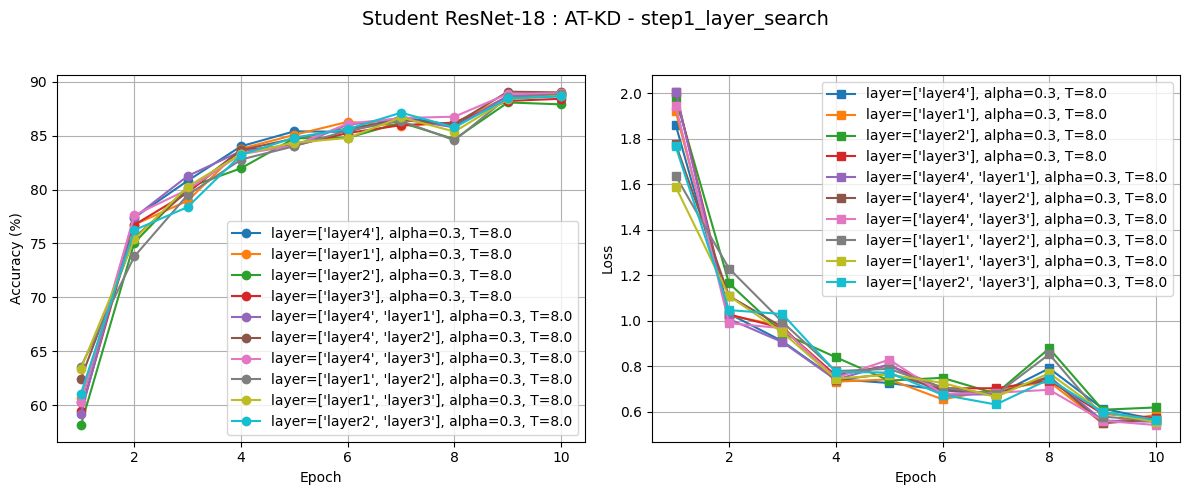

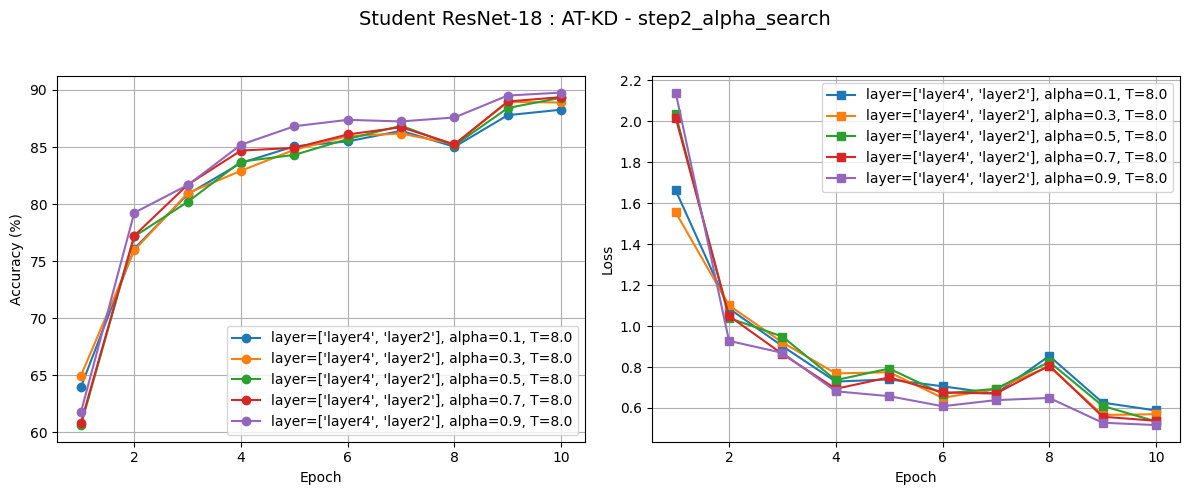

'step3_temperature_search' is empty. Skipping.


In [ ]:
plot_all_steps_with_loss(all_res_at, 'Student ResNet-18')

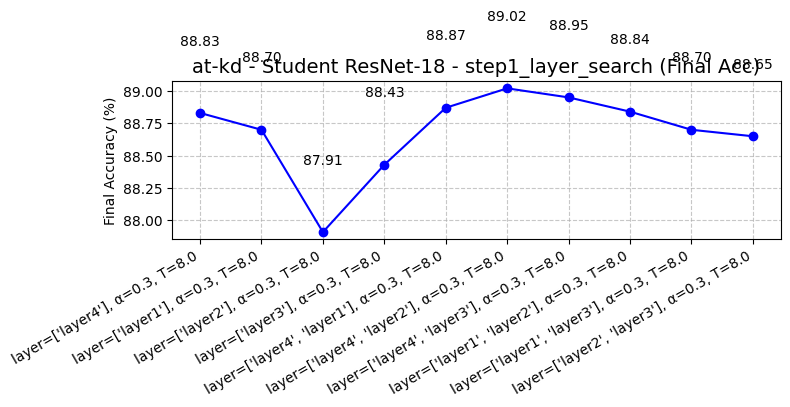

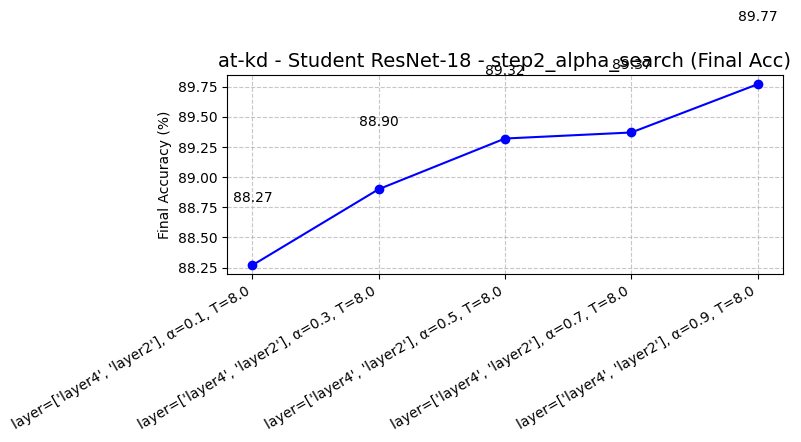

'step3_temperature_search' is empty. Skipping plot.


In [ ]:
plot_all_steps_final_line(all_res_at,'Student ResNet-18')